<a href="https://colab.research.google.com/github/m-aliabbas/Pneumonia-Train-Models-/blob/master/ResearchPaperInceptionLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from fastai.vision import *
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
from zipfile import ZipFile 
def unZip(file_name):
  with ZipFile(file_name, 'r') as zip: 
      zip.extractall() 
      print('Done!') 

In [0]:
file_name = '/content/drive/chestXRay.zip'

In [0]:
path="/content/drive/My Drive/"
file_name=path+'chestXRay.zip'

In [0]:
unZip(file_name)

Done!


In [0]:
unZip('chest_xray.zip')

Done!


In [0]:
import glob
import cv2
import numpy as np
%matplotlib inline
filesPos= sorted(glob.glob('chest_xray/train/NORMAL/*.jpeg'))
filesPos+=sorted(glob.glob('chest_xray/val/NORMAL/*.jpeg'))
filesPos+=sorted(glob.glob('chest_xray/test/NORMAL/*.jpeg'))



In [0]:
filesNeg=sorted(glob.glob('chest_xray/train/PNEUMONIA/*.jpeg'))
filesNeg+=sorted(glob.glob('chest_xray/val/PNEUMONIA/*.jpeg'))
filesNeg+=sorted(glob.glob('chest_xray/test/PNEUMONIA/*.jpeg'))

In [0]:
random.shuffle(filesNeg)
len(filesPos),len(filesNeg)

(1583, 4273)

In [0]:
filesNeg=filesNeg[:2100]

In [0]:
pos_labels=[[i,0] for i in filesPos]
neg_labels=[[i,1] for i in filesNeg]
ds=pos_labels+neg_labels

In [0]:
np.random.seed(4200)
import pandas as pd 
df = pd.DataFrame(ds,columns =['path', 'label']) 
def Randomizing(df):
    df2 = df.reindex(np.random.permutation(df.index))
    return df2
df=Randomizing(df)

In [0]:
from sklearn.model_selection import train_test_split
dfTrain,dfTest=train_test_split(df, shuffle=False,test_size=0.1, random_state=42)

In [0]:
len(dfTrain),len(dfTest)

(3314, 369)

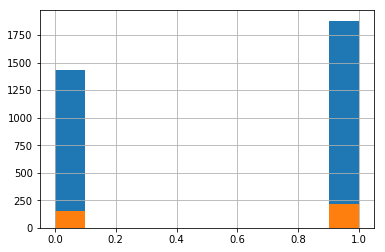

In [0]:
dfTrain['label'].hist()
dfTest['label'].hist()

In [0]:
bs =8
sz=224
tfms = get_transforms(do_flip=True,flip_vert=True,max_lighting=0.4,max_zoom=1.1)
src = (ImageList.from_df(df=dfTrain,path='',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.2) #Splitting the dataset
        .label_from_df(cols='label') #obtain labels from the level column
      )
data= (src.transform(tfms,size=224,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

In [0]:
data.classes

[0, 1]

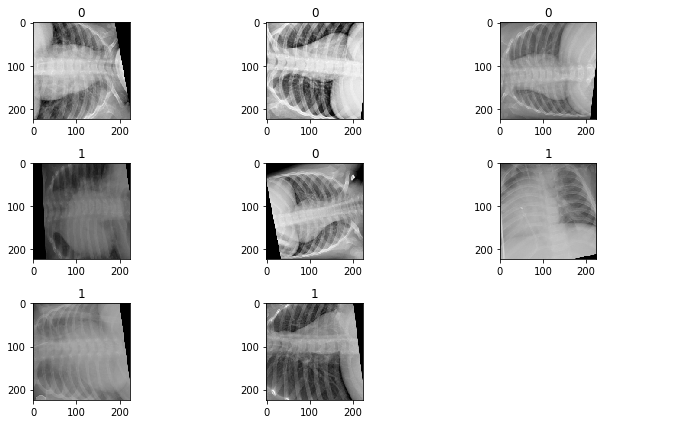

In [0]:
data.show_batch(rows=3, figsize=(10,6), hide_axis=False)

In [0]:
from sklearn.metrics import roc_auc_score,f1_score
def f1_score_a(y_pred,y_true,tens=True):
#     score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    f1a_score=f1_score(y_true, np.round(torch.sigmoid(y_pred)[:,1]), average='macro') 
    if tens:
#         score=tensor(score)
        f1a_score=tensor(f1a_score)
    else:
        f1a_score=f1a_score
    return f1a_score


In [0]:


import torch 
import torchvision
model = torchvision.models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth
100%|██████████| 52147035/52147035 [00:02<00:00, 24340050.07it/s]


In [0]:
model.cuda()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [0]:
num_ftrs = model.fc.in_features

model.fc=nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, 128),
    nn.Dropout(0.5),
    nn.Linear(128, 2),
)

In [0]:
model=model.cuda()

In [0]:
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [0]:
from fastai.callbacks import *

learn = Learner(data, model, metrics=[error_rate, accuracy,f1_score_a],callback_fns=[partial(CSVLogger,append=True),BnFreeze, partial(GradientClipping, clip=0.2)])

In [0]:
from fastai.callbacks import *
learn.fit(10,1e-06,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='f1_score_a')])

/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every imrpovement is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score_a,time
0,0.697279,0.651737,0.287009,0.712991,0.438785,02:26
1,0.660276,0.623762,0.194864,0.805136,0.496302,02:25
2,0.638813,0.594750,0.151057,0.848943,0.618904,02:24
3,0.632279,0.571665,0.145015,0.854985,0.734049,02:23
4,0.592667,0.536318,0.143505,0.856495,0.825912,02:24
5,0.575586,0.506749,0.137462,0.862538,0.839502,02:23
6,0.548292,0.486386,0.128399,0.871601,0.860375,02:23
7,0.517111,0.462036,0.143505,0.856495,0.854444,02:23
8,0.491424,0.435750,0.135952,0.864048,0.863738,02:23
9,0.471715,0.401340,0.120846,0.879154,0.865046,02:23


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Better model found at epoch 0 with f1_score_a value: 0.4387845993041992.
Better model found at epoch 1 with f1_score_a value: 0.49630242586135864.
Better model found at epoch 2 with f1_score_a value: 0.6189037561416626.
Better model found at epoch 3 with f1_score_a value: 0.7340489029884338.
Better model found at epoch 4 with f1_score_a value: 0.8259124159812927.
Better model found at epoch 5 with f1_score_a value: 0.8395021557807922.
Better model found at epoch 6 with f1_score_a value: 0.8603748083114624.
Better model found at epoch 8 with f1_score_a value: 0.8637378811836243.
Better model found at epoch 9 with f1_score_a value: 0.8650455474853516.


In [0]:
learn.load('bestmodel');

/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every imrpovement is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score_a,time
0,0.306304,0.314391,0.132931,0.867069,0.858779,02:23
1,0.306365,0.405308,0.134441,0.865559,0.840061,02:23
2,0.334293,0.483978,0.116314,0.883686,0.884468,02:23
3,0.380921,0.222009,0.063444,0.936556,0.929706,02:23
4,0.241252,0.217368,0.052870,0.947130,0.941135,02:23
5,0.325284,0.178389,0.040785,0.959215,0.953898,02:23
6,0.444741,0.179779,0.042296,0.957704,0.955593,02:23
7,0.191052,0.311484,0.055891,0.944109,0.940112,02:23
8,0.261503,0.290966,0.049849,0.950151,0.944716,02:23
9,0.264140,0.226799,0.039275,0.960725,0.955523,02:23


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Better model found at epoch 0 with f1_score_a value: 0.8587791919708252.
Better model found at epoch 2 with f1_score_a value: 0.8844680190086365.
Better model found at epoch 3 with f1_score_a value: 0.9297060370445251.
Better model found at epoch 4 with f1_score_a value: 0.9411349296569824.
Better model found at epoch 5 with f1_score_a value: 0.9538978934288025.
Better model found at epoch 6 with f1_score_a value: 0.9555930495262146.


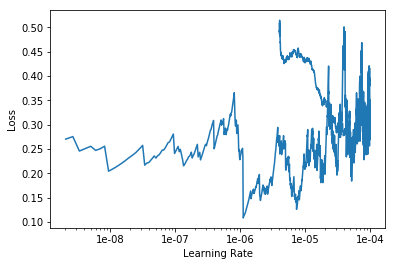

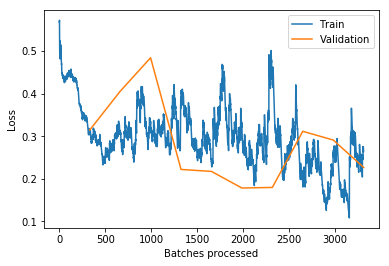

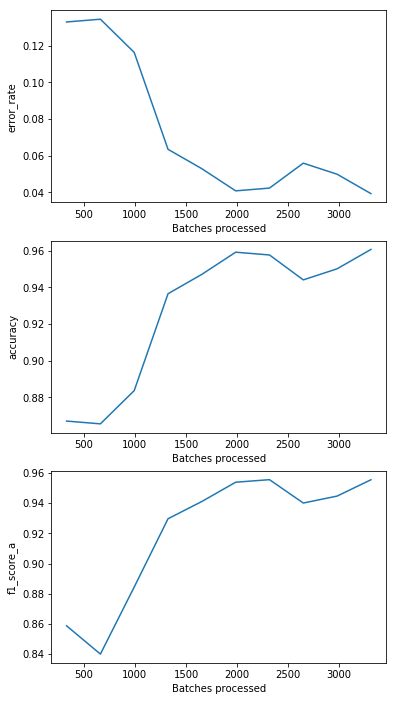

In [0]:

learn.unfreeze()
learn.fit_one_cycle(10,1e-04,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='f1_score_a')])
learn.recorder.plot()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

Precision of Model = 0.9417989417989417 Recall of Model  0.9834254143646409
F1 Score of Model = 0.9621621621621621


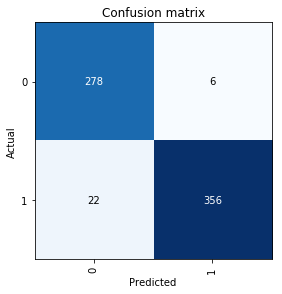

In [0]:
learn.load('bestmodel')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
conf=interp.confusion_matrix()
TrueNagitive=conf[0][0]
FalseNegative=conf[0][1]
TruePositive=conf[1][1]
FalsePositive=conf[1][0]
recal=TruePositive/(TruePositive+FalseNegative)
precision=TruePositive/(TruePositive+FalsePositive)
print("Precision of Model =",precision,"Recall of Model ", recal)
f1=2*((precision*recal)/(precision+recal))
print('F1 Score of Model =',f1)

In [0]:
bs =8
sz=224
tfms = get_transforms(do_flip=True,flip_vert=True,max_lighting=0.4,max_zoom=1.1)
src = (ImageList.from_df(df=dfTest,path='',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.0) #Splitting the dataset
        .label_from_df(cols='label') #obtain labels from the level column
      )
dataTest= (src.transform(tfms,size=224,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

In [0]:
learn.data.valid_dl = dataTest.train_dl

In [0]:
learn.validate()

[0.18566504, tensor(0.0489), tensor(0.9511), tensor(0.9390)]

Precision of Model = 0.958904109589041 Recall of Model  0.967741935483871
F1 Score of Model = 0.963302752293578


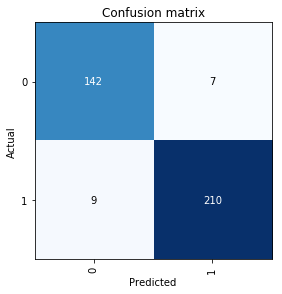

In [0]:
learn.load('bestmodel')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
conf=interp.confusion_matrix()
TrueNagitive=conf[0][0]
FalseNegative=conf[0][1]
TruePositive=conf[1][1]
FalsePositive=conf[1][0]
recal=TruePositive/(TruePositive+FalseNegative)
precision=TruePositive/(TruePositive+FalsePositive)
print("Precision of Model =",precision,"Recall of Model ", recal)
f1=2*((precision*recal)/(precision+recal))
print('F1 Score of Model =',f1)

In [0]:
!ls

chest_xray  chest_xray.zip  drive  history.csv	__MACOSX  models  sample_data


In [0]:
!rm -rf '/content/drive/My Drive/InceptionLRPne1'
!mkdir '/content/drive/My Drive/InceptionLRPne1'
!cp 'history.csv' '/content/drive/My Drive/InceptionLRPne1'


In [0]:
!ls '/content/drive/My Drive/' | grep 'LR'

AlexNetLRPne1
InceptionLRPne1
MobileLRPne1
Res101LRPne1
Res152LRPne1
Res18LRPne1
Res34LRPne1
Res50LRPne1
ShuffleNEtLRPne1
VGG16LRPne1
VGG19LRPne1
